In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Generative Adversarial Networks for Monet Paintings:

Generative Models are kind of unsupervised models that are trained to mimic the patterns in a dataset and produce examples very similar to those of training set. Generative models are of two sub models. These two submodels are called generators and discriminators. The role of the generator is to make fake example that look like the real example. On the other hand, the role of discriminator is to distinguish the real example from the fake example. These two sub models compete with each other up to the point when a balance between them established.

## Structure of this notebook:

* Description of the problem and data
* Exploratory data analysis (EDA)
* Analysis - model building and training
* Result
* Conclusion

In [1]:
# importing required libraries:

import numpy as np
import pandas as pd
import random
import shutil
import glob
import os
from scipy import stats
import time


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from tensorflow import keras
import tensorflow_addons  as tfa
from tensorflow.keras import Sequential, Model, layers, regularizers
from tensorflow.keras.layers import Conv2D, Dense, Input, Dropout, Activation, LeakyReLU, ReLU, BatchNormalization, Reshape, Flatten, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras.activations import relu, tanh
from keras.initializers import RandomNormal

## Description of the problem and data:

The Monet paintings have a unique style. Without having Claude Monet it might be difficult to repeat his painting style for the new scenes. The main goal of this competition/project is to apply the style of Monet painting to a new given photo so that it look like it has been painted by Claude Monet. This project uses special type Generative Adversarial Networks (GAN) which is mainly used for image translation. Images are initially different sizes. We are not given a dataframe to view or plot values. Instead, we will move on to the EDA and view some images. Prior to training, we will set our training data (images) and we will normalize all images.

In [2]:
# Input data:

print(os.listdir('../input'))

['gan-getting-started']


In [3]:
# Input data:

monet_tfrec_path = '../input/gan-getting-started/monet_tfrec'
monet_jpg_path = '../input/gan-getting-started/monet_jpg'

photo_tfrec_path = '../input/gan-getting-started/photo_tfrec'
photo_jpg_path = '../input/gan-getting-started/photo_jpg'

In [4]:
# saving the names of all the files with .jpg format and .tfrec format in a list:

monet_tfrec = tf.io.gfile.glob(monet_tfrec_path+'/*.tfrec')
monet_jpg = tf.io.gfile.glob(monet_jpg_path+'/*.jpg')
photo_tfrec = tf.io.gfile.glob(photo_tfrec_path+'/*.tfrec')
photo_jpg = tf.io.gfile.glob(photo_jpg_path+'/*.jpg')

# checking the number of monet examples and photo examples:
print(len(monet_tfrec), len(photo_tfrec))
print(len(monet_jpg), len(photo_jpg))

5 20
300 7038


## Exploratory data analysis (EDA):

This sections explores the datasets by plotting some training examples. In addition, some histograms for different color channels in the training set are displayed. After cropping the images, we visualize them below.

In [5]:
# Loading an image files by its path:
def Load_Image(path):
    image_path = tf.io.read_file(path)
    image_path = tf.image.decode_image(image_path, channels = 3)
    image_path = tf.image.convert_image_dtype(image_path, tf.float32)
    image_path = tf.reshape(image_path, [256, 256, 3])
    return image_path


# The function below decode image, rescales and reshape the images: 
def Decode_Image(path):
    images = tf.image.decode_image(path, channels = 3)
    images = (tf.cast(images, tf.float32) /127.5) - 1
    images = tf.reshape(images, [256, 256, 3])
    return images


# The function below decode image, rescales and reshape the images: 
def Process_Image(path):
    format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),\
        'image' : tf.io.FixedLenFeature([], tf.string),\
        'target' : tf.io.FixedLenFeature([], tf.string) }
    
    paths = tf.io.parse_single_example(path, format)
    image = Decode_Image(paths['image'])
    return image


# Loads the whole dataset to a tensorflow dataset object:
def Load_Data(name):
    dataset = tf.data.TFRecordDataset(name)
    dataset = dataset.map(Process_Image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    return dataset


# To crop the images:
def Crop_Image(image, box):
    img = Image.open(image)
    img = img.crop(box)
    return img


In [6]:
# Loading the whole dataset:

monet_data = Load_Data(monet_tfrec).batch(1)
photo_data = Load_Data(photo_tfrec).batch(1)

### Visulaization of Some Images:

(-0.5, 255.5, 255.5, -0.5)

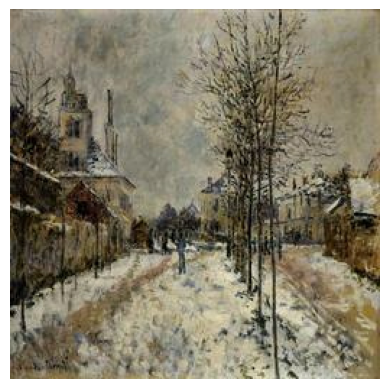

In [7]:
# Visualization:

sample = next(iter(monet_data))
plt.imshow(sample[0]*0.5 + 0.5)
plt.axis('off')

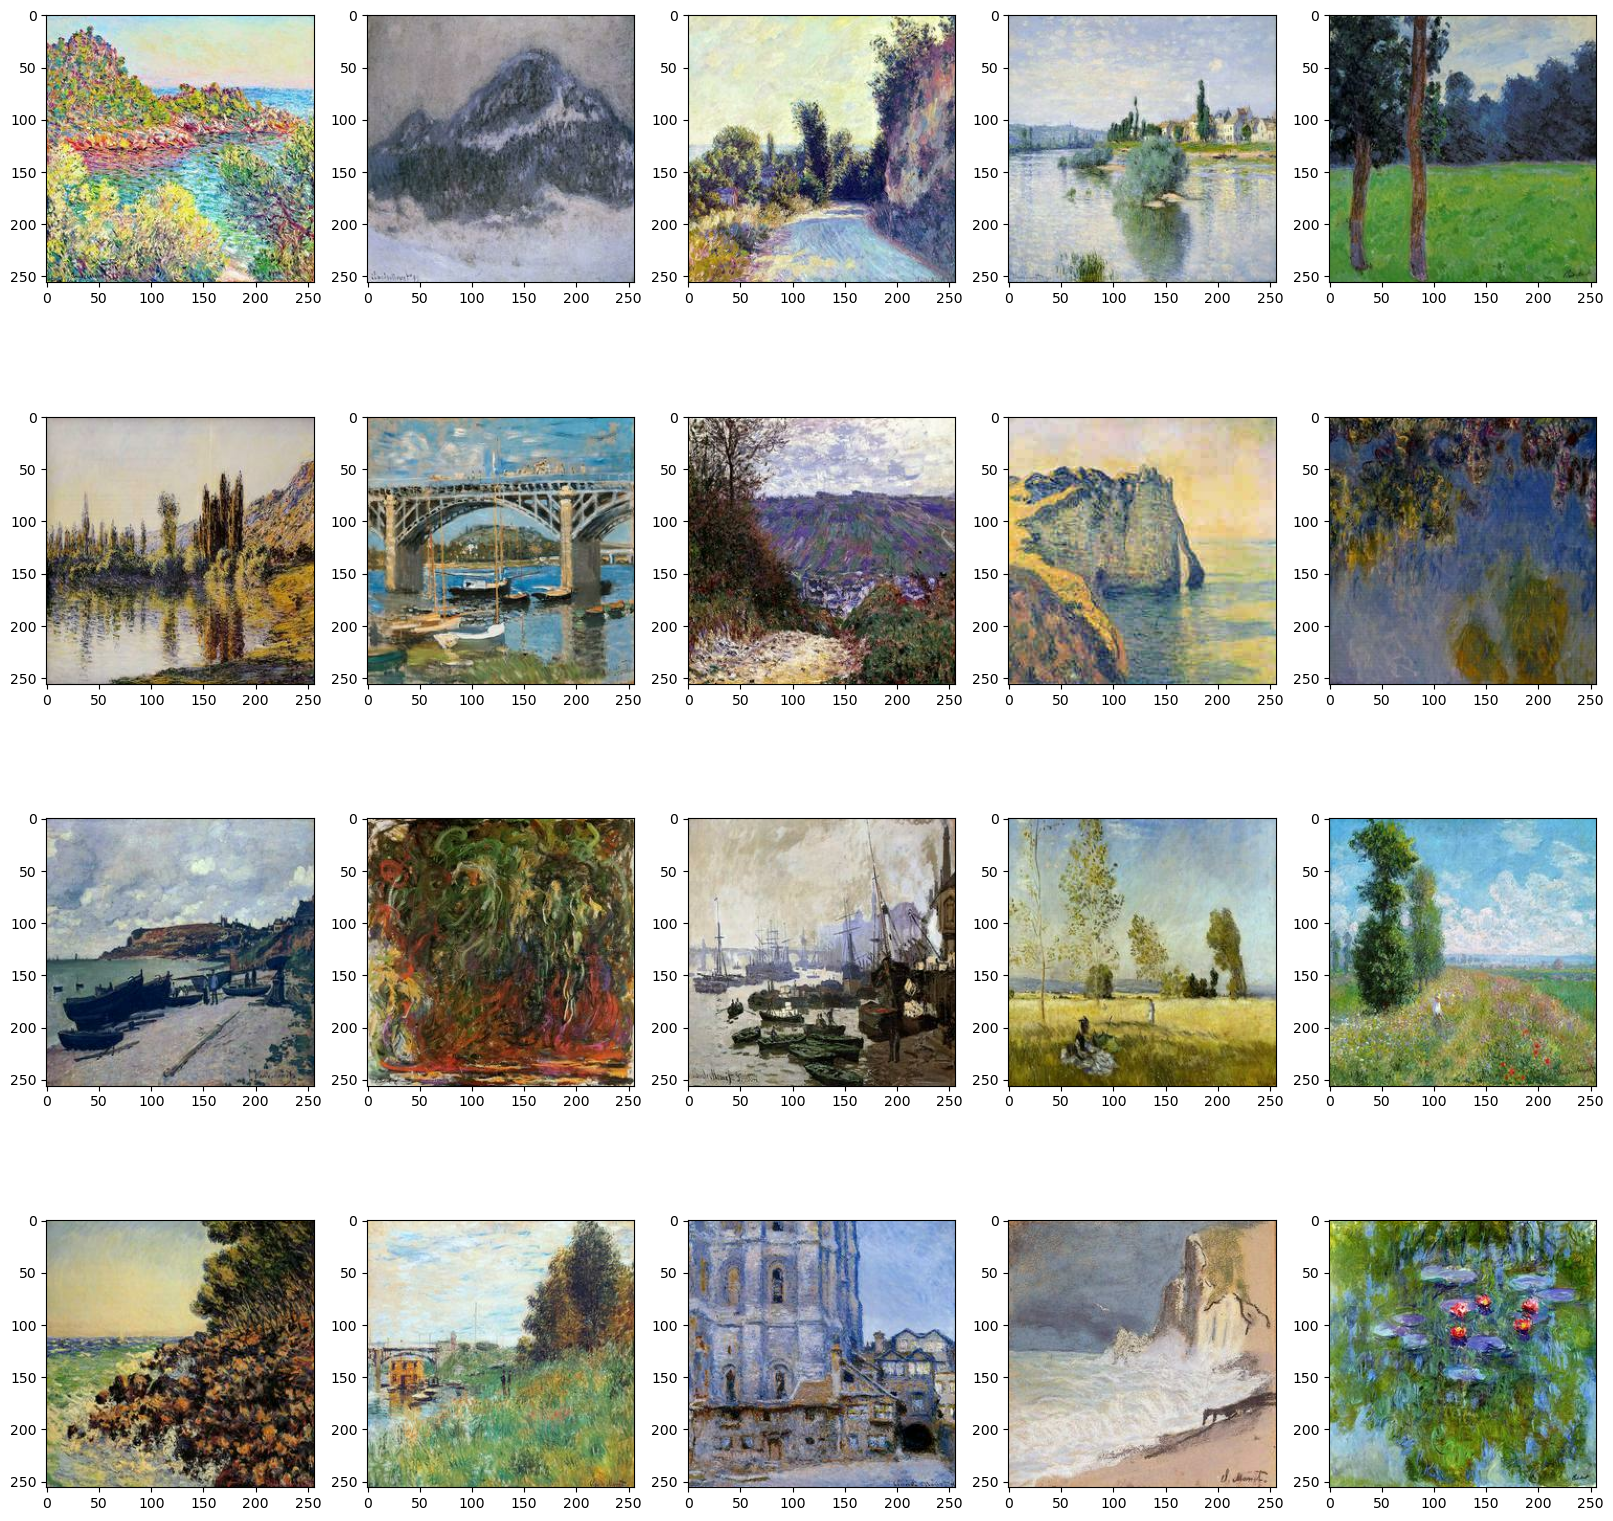

In [8]:
# Display images from the monet dataset:

fig, ax = plt.subplots(4, 5, figsize = (20, 20))

jpg = random.sample(monet_jpg, 20)

for idx, name in enumerate(jpg):
    img = Load_Image(name)
    ax[idx//5, idx%5].imshow(img)

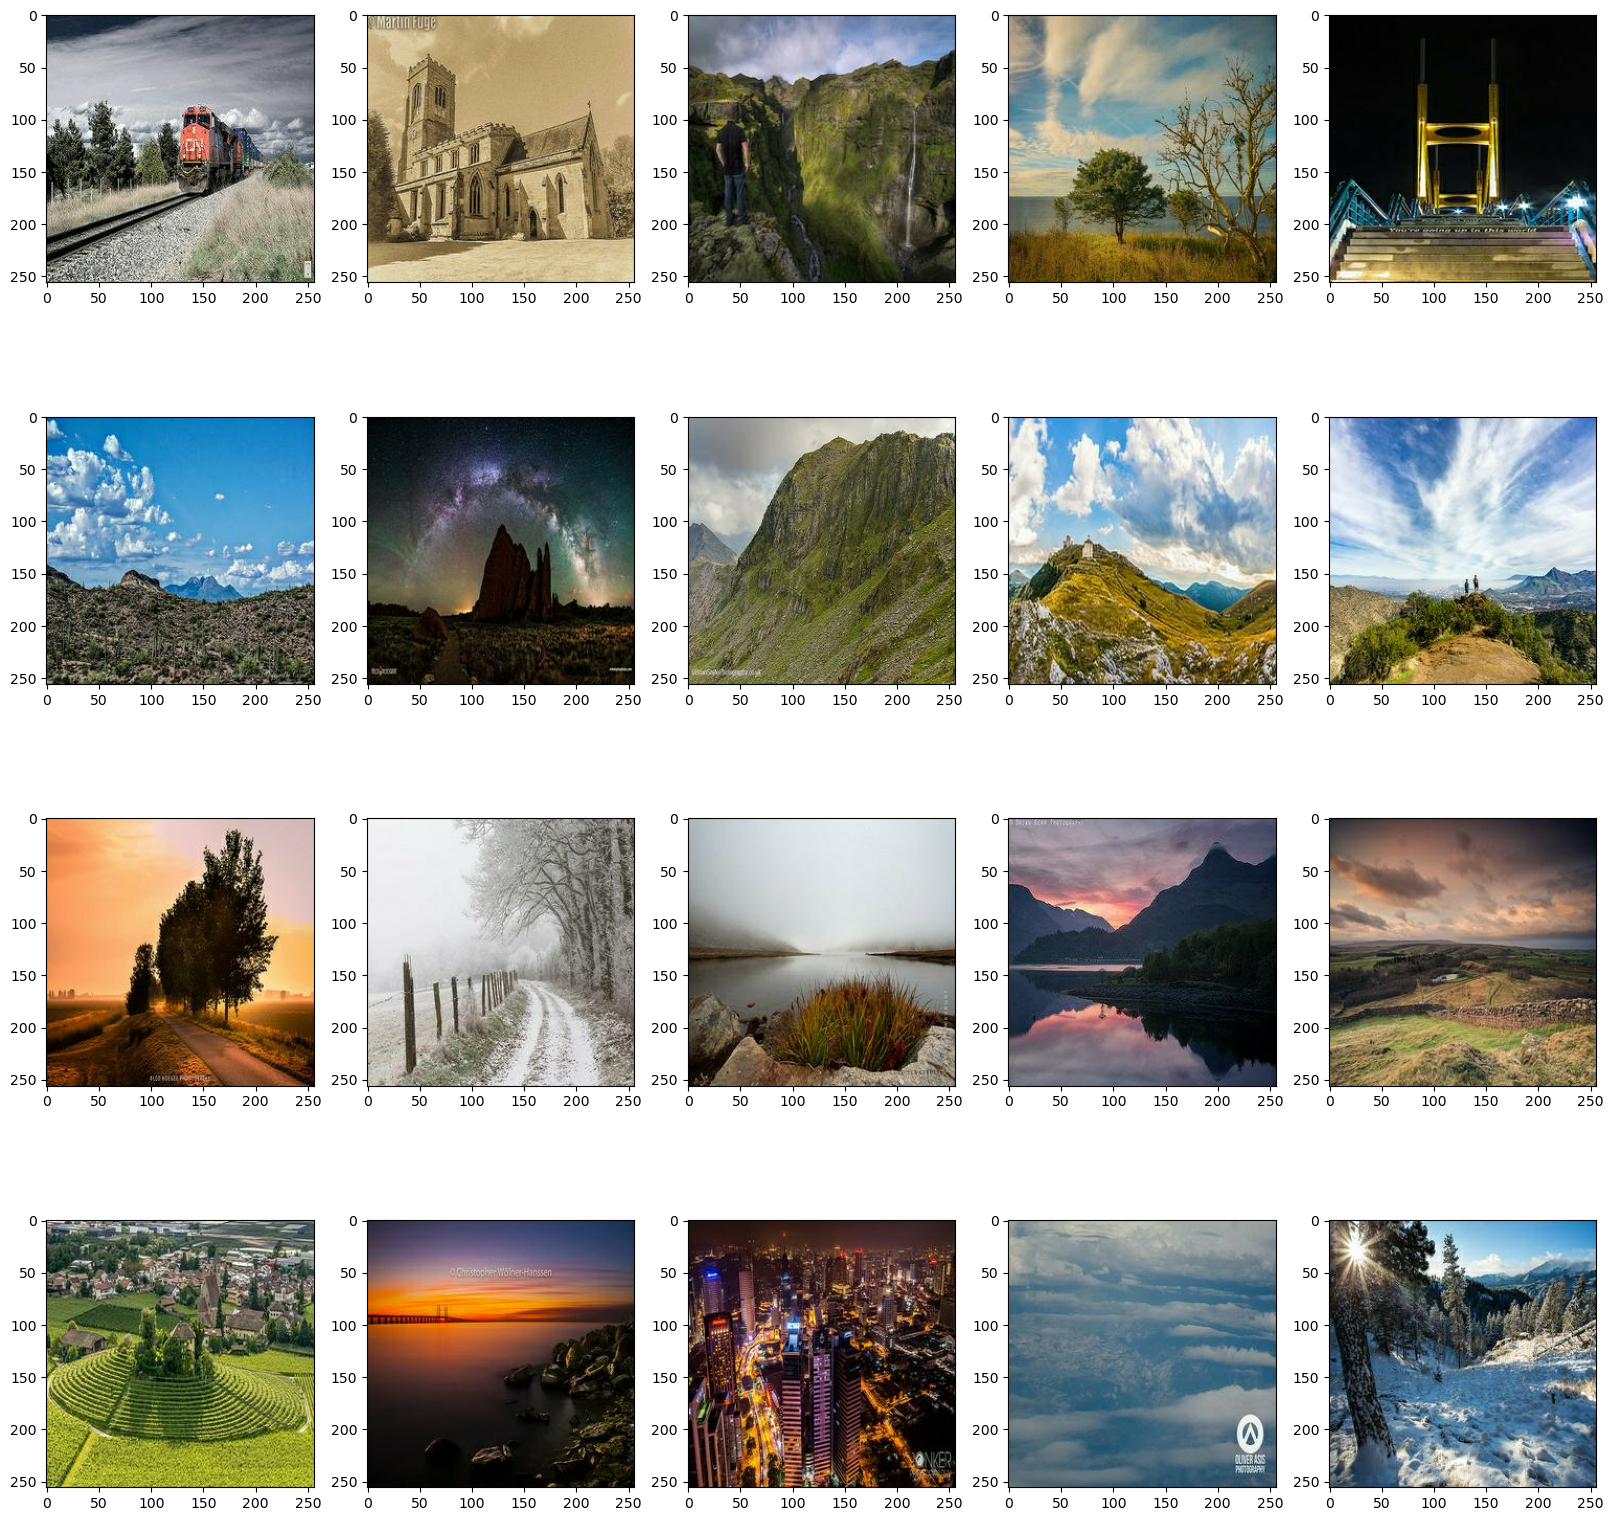

In [9]:
# Display images from the photo dataset:

fig, ax = plt.subplots(4, 5, figsize = (20, 20))

jpg = random.sample(photo_jpg, 20)

for idx, name in enumerate(jpg):
    img = Load_Image(name)
    ax[idx//5, idx%5].imshow(img)

## Analysis - model building and training:

#### Model Architecture:

* Used Architecture : The architecture chosen for this project is DCGAN.

#### Hyperparameter Tuning:

The hyperparemeter tuning for the chosen model could be performed by using the advice from experts or in trial-and-error fashion.

In [10]:
# Create a function to build the generator model:

def generator_model():
    initializer  = RandomNormal(mean = 0, stddev = 0.02)
    
    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False, input_shape = [256, 256, 3], kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #model.add(Reshape((8, 8, 512)))

    model.add(Conv2D(filters = 128, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())    
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 256, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))


    model.add(Conv2DTranspose(filters = 265, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2DTranspose(filters = 128, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2DTranspose(filters = 3, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    return model

In [11]:
# Create a function to build the discriminator model:

def discriminator_model():
    initializer  = RandomNormal(mean = 0, stddev = 0.02)
    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (4, 4), strides = (2,2), padding = 'same', input_shape = [256,256,3], kernel_initializer = initializer, use_bias = False))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 128, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 256, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 1, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    

    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    model.add(Flatten())
       
    return model
    

In [12]:
# Summary:

optimizer = Adam(0.0001)
generator = generator_model()
generator.compile(loss = 'binarycrossentropy', optimizer = optimizer, metrics = ['accuracy'])
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      3072      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131072    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0

In [13]:
# Summary:

discriminator = discriminator_model()
discriminator.compile(loss = 'binarycrossentropy', optimizer = optimizer, metrics = ['accuracy'])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      3072      
                                                                 
 re_lu (ReLU)                (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       131072    
                                                                 
 re_lu_1 (ReLU)              (None, 64, 64, 128)       0         
                                                      

In [14]:
# Combining both generator and discriminatir:

optimizer = Adam(0.0001)

def gan_model(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


generator = generator_model()
discriminator = discriminator_model()

GAN = gan_model(generator, discriminator)
GAN.compile(loss = 'binarycrossentropy', optimizer = optimizer, metrics = ['accuracy'])
GAN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       2296112   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 664581    
                                                                 
Total params: 2,960,693
Trainable params: 2,958,107
Non-trainable params: 2,586
_________________________________________________________________


(1, 256, 256, 3)
(256, 256)


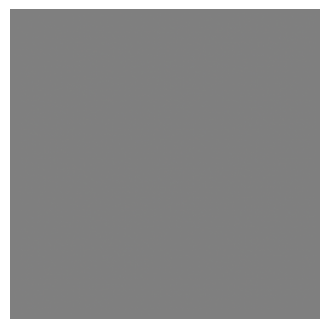

In [16]:
# Visualize one sample example and make sure its working correct:

noise = tf.random.normal([1,256, 256, 3])
image = generator(noise)
generated_image = generator(noise, training = False)
print(generated_image.shape)
print(generated_image[0, :, :, 0].shape)

def generate_images(row = 1,col = 1, is_norm = False):
    plt.figure(figsize = (4*row, 5*col))    
    for ele in range(1,1+row*col):        
        noise = tf.random.normal([1, 256, 256, 3])
        plt.subplot(row, col, ele)
        if(is_norm):
            plt.imshow(generator(noise)[0, :, :, :]*255)
        else:            
            plt.imshow(generator(noise)[0, :, :, :]*0.5 + 0.5)
        plt.axis('off')
        
generate_images()

In [17]:
# Training step and Training loop:

discriminator = discriminator_model()
gen_pred = discriminator(generated_image, training = False)
print(gen_pred)

tf.Tensor([[0.50000197]], shape=(1, 1), dtype=float32)


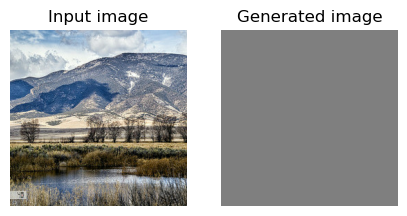

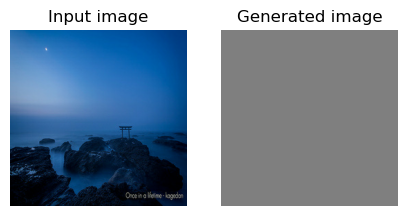

In [18]:
df = iter(photo_data)
for ele in range(2):
        example_sample = next(df)
        generated_sample = generator(example_sample)
        
        f = plt.figure(figsize=(5, 5))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [19]:
# Create two separate loss functions for the generator and discriminator:

cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
# Set the hyperparameters to be used for training:

EPOCHS = 5
sample_interval = EPOCHS / 10
BATCH_SIZE = 32

In [21]:
# Create a function that trains one step of a GAN:

@tf.function
def train_step(image_batch):
    noise = tf.random.normal([1,256, 256, 3])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: 
        
        generated_image = generator(noise, training=True)

        discriminator_pred_gen = discriminator(generated_image, training=True)

        discriminator_pred_ori= discriminator(image_batch, training=True)


        discriminator_loss = cross_entropy(tf.ones_like(discriminator_pred_ori),discriminator_pred_ori) + cross_entropy(tf.zeros_like(discriminator_pred_gen), discriminator_pred_gen)
        generator_loss = cross_entropy(tf.ones_like(discriminator_pred_gen), discriminator_pred_gen)
        
    generator_grad = gen_tape.gradient(generator_loss, generator.trainable_variables)
    discriminator_grad = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    optimizer.apply_gradients(zip(generator_grad,generator.trainable_variables))
    optimizer.apply_gradients(zip(discriminator_grad,discriminator.trainable_variables))    

In [22]:
# Create a function that trains the GAN on multiple epochs:

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        print(f"Time for epoch {epoch+ 1} is : {time.time()-start}")

In [23]:
train(monet_data, EPOCHS)

Time for epoch 1 is : 195.55780363082886
Time for epoch 2 is : 195.7468798160553
Time for epoch 3 is : 193.1521532535553
Time for epoch 4 is : 196.68905925750732
Time for epoch 5 is : 196.29826045036316


In [24]:
# Create new directory and generate images:

import PIL
from PIL import Image

SAVE_PATH = './Monet_output'

if not os.path.exists(SAVE_PATH ):
    os.mkdir(SAVE_PATH )
else:
    shutil.rmtree(SAVE_PATH )
    os.mkdir(SAVE_PATH )

for index, photo in enumerate(photo_data):

    prediction = generator(photo, training = False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

    PIL.Image.fromarray(prediction).save(SAVE_PATH  + f'/image {index+1}.jpg')

shutil.make_archive('images', 'zip', SAVE_PATH )


'/kaggle/working/images.zip'

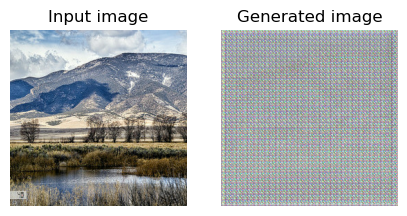

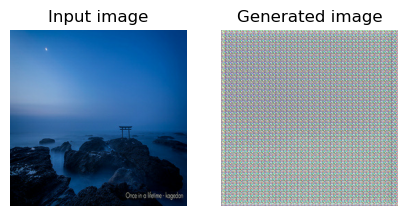

In [25]:
ds_iter = iter(photo_data)
for n_sample in range(2):
        example_sample = next(ds_iter)
        generated_sample = generator(example_sample)
        
        f = plt.figure(figsize=(5, 5))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

## Conclusion:

Our model did learn and begin to take shape. However, it is obvious our model did not create convincing images. There are a few suggestions: increase the number of epochs, modify the architecture and try transfer learning. 

Something that I would have liked to try was transfer learning during the generator part so that the model doesn't have to learn from 0. In addition, I think increasing the number of epochs would have useful. 

 This project just scrapes the surface of GANs and how much they can accomplish.

GitHub like: https://github.com/shriyutha/Monet-paintings-DCGAN-Deeplearning